<a href="https://colab.research.google.com/github/ZainabIftikhar1204/DL_Assg2_Leaderboard/blob/main/25280064_PA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

np.random.seed(42)

In [113]:
BATCH_SIZE = 128
EPOCHS = 25

In [2]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_DIR = '/content/drive/MyDrive/notebook data/processed_data' # Ensure this matches where you ran make_dataset.py
TRAIN_FILE = os.path.join(DATA_DIR, 'quickdraw_train.npz')
TEST_FILE = os.path.join(DATA_DIR, 'quickdraw_test.npz')


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
data_transform = transforms.Compose([
    # transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1,)),
])

In [72]:
# ==========================================
# 2. DATASET CLASS (The NPZ Loader)
# ==========================================

class QuickDrawDataset(Dataset):
    def __init__(self, file_path, mode='train'):
        """
        Args:
            file_path (str): Path to the .npz file
            mode (str): 'train' (loads images & labels) or 'test' (loads images only)
        """
        self.mode = mode
        # self.transform = data_transform
        print("file path:", file_path)


        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Could not find file: {file_path}")

        print(f"Loading {mode} data from {file_path}...")
        data = np.load(file_path)

        if mode == 'train':
            # Load x_train and y_train
            self.x = data['x_train']
            self.y = data['y_train']
            self.classes = data['class_names']
            print(f"Loaded {len(self.x)} training samples. Classes: {len(self.classes)}")

        elif mode == 'test':
            # Load test_images (for leaderboard inference)
            self.x = data['test_images']
            self.y = None
            print(f"Loaded {len(self.x)} test images.")

        # Pre-processing:
        # Convert to Float Tensor and Normalize (0-255 -> 0-1)
        self.x = torch.from_numpy(self.x).float() / 255.0

        if self.y is not None:
            self.y = torch.from_numpy(self.y).long()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]
        if self.mode == 'train':
            label = self.y[idx]
            # if self.transform:
            #   img = img.numpy()
            #   img = Image.fromarray(img.astype(np.uint8))
            #   img = self.transform(img)
            return img, label
        else:
            return img

In [73]:
# ==========================================
# 3. PREPARE DATALOADERS
# ==========================================

CLASSES = ['apple', 'baseballbat', 'basketball', 'clock', 'compass', 'cookie', 'donut', 'ladder', 'mountain', 'pizza', 'rabbit', 'soccerball', 'spider', 't-shirt', 'wheel']

# 1. Load the Training Data
full_train_dataset = QuickDrawDataset(TRAIN_FILE, mode='train')
NUM_CLASSES = len(full_train_dataset.classes)

# 2. Create Validation Split (80% Train / 20% Val)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# 3. Create Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)}")

file path: /content/drive/MyDrive/notebook data/processed_data/quickdraw_train.npz
Loading train data from /content/drive/MyDrive/notebook data/processed_data/quickdraw_train.npz...
Loaded 60000 training samples. Classes: 15
Train samples: 48000 | Validation samples: 12000


In [48]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]

print(f"Img: {img.shape} , Label: {label}")

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64])
Img: torch.Size([784]) , Label: 8


In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [95]:
def compute_train_and_val_acc(model):
  train_accs = []
  val_accs = []
  train_losses = []
  val_losses = []

  min_valid_loss = np.inf

  for e in range(EPOCHS):

      model.train()
      train_loss = 0.0
      train_correct = 0
      train_total = 0

      for data, labels in train_loader:

          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()

          optimizer.zero_grad()
          target = model(data)
          loss = criterion(target, labels)
          loss.backward()
          optimizer.step()

          train_loss += loss.item()

          _, predicted = torch.max(target, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()

      train_accuracy = 100 * train_correct / train_total
      train_accs.append(train_accuracy)
      train_losses.append(train_loss / len(train_loader))



      # 🔵 VALIDATION
      model.eval()
      valid_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for data, labels in val_loader:

              if torch.cuda.is_available():
                  data, labels = data.cuda(), labels.cuda()

              target = model(data)
              loss = criterion(target, labels)

              valid_loss += loss.item()

              _, predicted = torch.max(target, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      val_accuracy = 100 * val_correct / val_total
      val_accs.append(val_accuracy)
      val_losses.append(valid_loss / len(val_loader))


      print(f'''
  Epoch {e+1}

  Train Loss: {train_loss / len(train_loader):.4f}
  Train Acc: {train_accuracy:.2f}%

  Val Loss: {valid_loss / len(val_loader):.4f}
  Val Acc: {val_accuracy:.2f}%
      ''')


      if valid_loss < min_valid_loss:
          print("Validation loss decreased — saving model")
          min_valid_loss = valid_loss
          torch.save(model.state_dict(), 'saved_model.pth')

  return train_accs, val_accs, train_losses, val_losses

In [96]:
def plot_accs_and_losses(train_acc, val_acc, train_loss, val_loss):
  x = np.arange(1, EPOCHS+1)

  plt.plot(x, train_acc, label='Train accuracy')
  plt.plot(x, val_acc, label='Val accuracy')

  plt.plot(x, train_loss, '-', label='Training Loss')
  plt.plot(x, val_loss, '-', label='Validation Loss')


  plt.xlabel("Epochs")
  plt.ylabel("Losses and accuracy")
  plt.title("Training & Val Losses + Accuracies")
  plt.legend()
  plt.show()

In [76]:
def print_model_size(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Statistics:")
    print(f"  Total Parameters: {total_params:,}")
    if total_params > 3000000:
        print("  ⚠️ WARNING: You are over the 3M parameter limit!")
    else:
        print("  ✅ Parameter count is within limits.")

# print_model_size(model)

## Pancake Model


In [ ]:
# ==========================================
# 4. YOUR IMPLEMENTATION HERE
# ==========================================
class BaselineMLP ( nn.Module ) :
  def __init__ ( self , input_size =784 , num_classes =10) :
    super ( BaselineMLP , self ).__init__ ()
    # First Hidden Layer : 512 neurons
    self.fc1 = nn.Linear (input_size, 2048)

    self.fc2 = nn.Linear(2048, 1024)
    # Output Layer : Maps to 10 classes
    self.fc3 = nn.Linear (1024, num_classes )

  def forward ( self , x ) :
    # 1. Flatten the image
    x = x.view (-1 ,784)

    # 2. Pass through first layer + Activation
    x = self.fc1(x)
    x = F.relu(x) # Rectified Linear Unit

    # second layer
    x = self.fc2(x)
    x = F.relu(x)

    # 3. Output layer (Raw logits )
    x = self.fc3(x)
    return x


In [ ]:
pancake_model = BaselineMLP(num_classes=NUM_CLASSES).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pancake_model.parameters(), lr=0.01)

In [ ]:
# for the pancake
pc_train_accs, pc_val_accs, pc_train_losses, pc_val_losses = compute_train_and_val_acc(pancake_model)


  Epoch 1

  Train Loss: 1.3272
  Train Acc: 59.59%

  Val Loss: 1.0430
  Val Acc: 64.89%
      
Validation loss decreased — saving model

  Epoch 2

  Train Loss: 0.9781
  Train Acc: 67.72%

  Val Loss: 1.0327
  Val Acc: 67.31%
      
Validation loss decreased — saving model

  Epoch 3

  Train Loss: 0.9078
  Train Acc: 69.92%

  Val Loss: 0.9791
  Val Acc: 69.16%
      
Validation loss decreased — saving model

  Epoch 4

  Train Loss: 0.8556
  Train Acc: 71.38%

  Val Loss: 0.9930
  Val Acc: 68.13%
      

  Epoch 5

  Train Loss: 0.8217
  Train Acc: 72.61%

  Val Loss: 0.9832
  Val Acc: 69.52%
      

  Epoch 6

  Train Loss: 0.7926
  Train Acc: 73.53%

  Val Loss: 0.9612
  Val Acc: 70.42%
      
Validation loss decreased — saving model

  Epoch 7

  Train Loss: 0.7777
  Train Acc: 74.10%

  Val Loss: 1.0822
  Val Acc: 67.90%
      

  Epoch 8

  Train Loss: 0.7525
  Train Acc: 74.90%

  Val Loss: 1.0079
  Val Acc: 70.04%
      

  Epoch 9

  Train Loss: 0.7298
  Train Acc: 75.51%

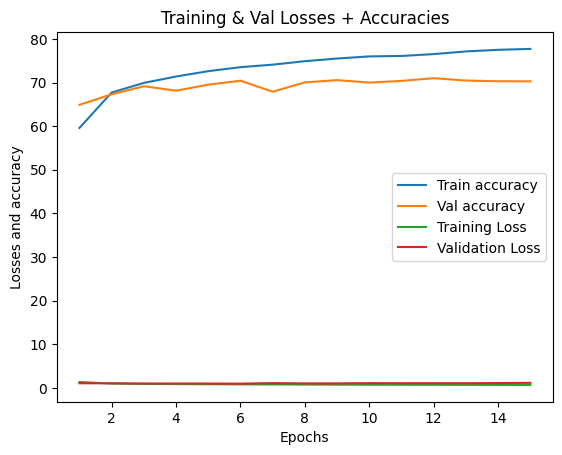

In [ ]:
plot_accs_and_losses(pc_train_accs, pc_val_accs, pc_train_losses, pc_val_losses)

In [ ]:
print_model_size(pancake_model)


Model Statistics:
  Total Parameters: 3,721,231
  ⚠️ WARNING: You are over the 3M parameter limit!


## Deep Model

In [ ]:
class DeepMLP ( nn.Module ) :
  def __init__ ( self , input_size =784 , num_classes =10) :
    super ( DeepMLP , self ).__init__ ()
    # # First Hidden Layer : 512 neurons
    # self.fc1 = nn.Linear (input_size, 2048)

    # self.fc2 = nn.Linear(2048, 1024)
    # # Output Layer : Maps to 10 classes
    # self.fc3 = nn.Linear (1024, num_classes )
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 256), #layer 1
        nn.ReLU(),
        nn.Linear(256, 128), #layer 2
        nn.ReLU(),
        nn.Linear(128, 128), #layer 3
        nn.ReLU(),
        nn.Linear(128, 64), #layer 4
        nn.ReLU(),
        nn.Linear(64, num_classes), #o/p layer
    )

  def forward ( self , x ) :
    x = self.layers(x)
    return x


In [ ]:
deep_model = DeepMLP(num_classes=NUM_CLASSES).to(device)

In [ ]:
#using same final activation and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.001)
deep_train_accs, deep_val_accs, deep_train_losses, deep_val_losses = compute_train_and_val_acc(deep_model)


  Epoch 1

  Train Loss: 1.4040
  Train Acc: 53.22%

  Val Loss: 1.0635
  Val Acc: 65.11%
      
Validation loss decreased — saving model

  Epoch 2

  Train Loss: 0.9864
  Train Acc: 67.31%

  Val Loss: 0.9343
  Val Acc: 68.62%
      
Validation loss decreased — saving model

  Epoch 3

  Train Loss: 0.8737
  Train Acc: 70.79%

  Val Loss: 0.8707
  Val Acc: 71.20%
      
Validation loss decreased — saving model

  Epoch 4

  Train Loss: 0.7841
  Train Acc: 73.90%

  Val Loss: 0.8465
  Val Acc: 72.18%
      
Validation loss decreased — saving model

  Epoch 5

  Train Loss: 0.7130
  Train Acc: 76.14%

  Val Loss: 0.7924
  Val Acc: 74.12%
      
Validation loss decreased — saving model

  Epoch 6

  Train Loss: 0.6487
  Train Acc: 78.22%

  Val Loss: 0.7743
  Val Acc: 75.32%
      
Validation loss decreased — saving model

  Epoch 7

  Train Loss: 0.5905
  Train Acc: 80.33%

  Val Loss: 0.7863
  Val Acc: 75.02%
      

  Epoch 8

  Train Loss: 0.5400
  Train Acc: 81.79%

  Val Loss: 0.

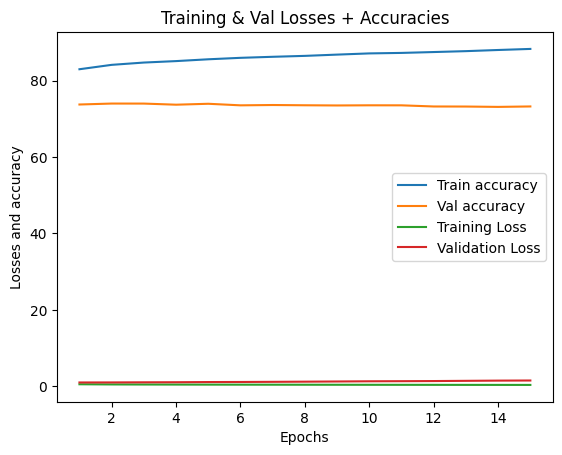

In [ ]:
plot_accs_and_losses(deep_train_accs, deep_val_accs, deep_train_losses, deep_val_losses)

In [ ]:
print_model_size(deep_model)


Model Statistics:
  Total Parameters: 259,599
  ✅ Parameter count is within limits.


## Final Model

In [108]:
class FinalMLP ( nn.Module ) :
  def __init__ ( self , input_size =784 , num_classes =10) :
    super ( FinalMLP , self ).__init__ ()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 512), #layer 1
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, 512), #layer 2
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, 256), #layer 2
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(256, 128), #layer 3
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, 64), #layer 4
        nn.ReLU(),
        # nn.Linear(64, 32), #layer 4
        # nn.ReLU(),
        nn.Linear(64, num_classes), #o/p layer
    )

  def forward ( self , x ) :
    x = self.layers(x)
    return x


In [114]:
final_model = FinalMLP(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005, weight_decay=0.0001)

final_train_accs, final_val_accs, final_train_losses, final_val_losses = compute_train_and_val_acc(final_model)


  Epoch 1

  Train Loss: 1.4134
  Train Acc: 54.71%

  Val Loss: 0.9541
  Val Acc: 67.73%
      
Validation loss decreased — saving model

  Epoch 2

  Train Loss: 0.9846
  Train Acc: 67.66%

  Val Loss: 0.8476
  Val Acc: 71.58%
      
Validation loss decreased — saving model

  Epoch 3

  Train Loss: 0.8938
  Train Acc: 70.40%

  Val Loss: 0.8187
  Val Acc: 72.44%
      
Validation loss decreased — saving model

  Epoch 4

  Train Loss: 0.8307
  Train Acc: 72.40%

  Val Loss: 0.7664
  Val Acc: 74.39%
      
Validation loss decreased — saving model

  Epoch 5

  Train Loss: 0.7884
  Train Acc: 74.01%

  Val Loss: 0.7351
  Val Acc: 75.73%
      
Validation loss decreased — saving model

  Epoch 6

  Train Loss: 0.7459
  Train Acc: 75.43%

  Val Loss: 0.7235
  Val Acc: 75.84%
      
Validation loss decreased — saving model

  Epoch 7

  Train Loss: 0.7133
  Train Acc: 76.47%

  Val Loss: 0.7113
  Val Acc: 76.64%
      
Validation loss decreased — saving model

  Epoch 8

  Train Loss: 0

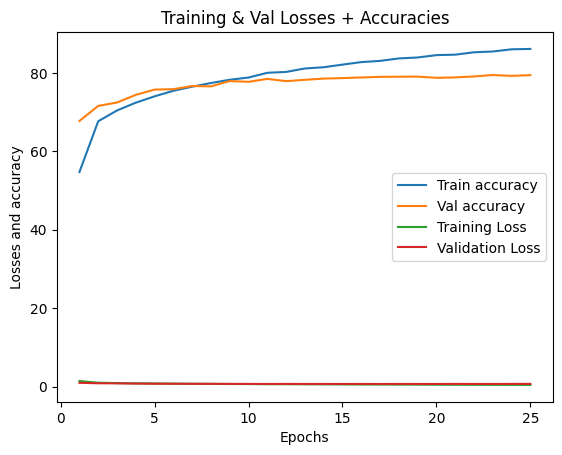

In [115]:
plot_accs_and_losses(final_train_accs, final_val_accs, final_train_losses, final_val_losses)

In [116]:
print_model_size(final_model)


Model Statistics:
  Total Parameters: 840,847
  ✅ Parameter count is within limits.


## Final inference and Model size

In [117]:
import pandas as pd
from sklearn.metrics import accuracy_score

# ==========================================
# 5. INFERENCE & LEADERBOARD VERIFICATION
# ==========================================
print("\n" + "="*40)
print("   GENERATING SUBMISSION FILE")
print("="*40)
# 1. Load Test Images
test_dataset = QuickDrawDataset(TEST_FILE, mode='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def get_predictions(model, loader):
    model.eval()
    model.to(DEVICE)
    preds = []
    with torch.no_grad():
        for batch in loader:
            X = batch.to(DEVICE)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
    return preds

# 2. Run Inference
print("Running inference on test set...")
predictions = get_predictions(final_model, test_loader)

# 3. Save as Comma-Separated Text File
submission_file = "submission.txt"
print(f"Saving predictions to '{submission_file}'...")

# Convert list of ints to comma-separated string (e.g., "0,4,9,2...")
submission_string = ",".join(map(str, predictions))

with open(submission_file, "w") as f:
    f.write(submission_string)
print(f"-> Copy & paste the results of this file to the portal.")


   GENERATING SUBMISSION FILE
file path: /content/drive/MyDrive/notebook data/processed_data/quickdraw_test.npz
Loading test data from /content/drive/MyDrive/notebook data/processed_data/quickdraw_test.npz...
Loaded 15000 test images.
Running inference on test set...
Saving predictions to 'submission.txt'...
-> Copy & paste the results of this file to the portal.
